<a href="https://colab.research.google.com/github/Silvmike/LLM-Engineering-Essentials/blob/main/topic2/a.1_llm_tools_and_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Engineering Essentials by Nebius Academy

Course github: [link](https://github.com/Nebius-Academy/LLM-Engineering-Essentials/tree/main)

The course is in development now, with more materials coming soon. [Subscribe to stay updated](https://academy.nebius.com/llm-engineering-essentials/update/)

# A.1. LLM Agents

In this notebook, we'll update the `SimpleChatNPC` class we've developed in the [Creating an LLM-powered character](https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic1/1.7_creating_an_llm-powered_character.ipynb) notebook, turning it into an agent while learning about tool usage and agents along the way.

## Setting things up

In [1]:
!pip install -q openai

In [2]:
import os

os.environ["NEBIUS_API_KEY"] = "NEBIUS_API_KEY"

In [3]:
from openai import OpenAI
client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)
model = "meta-llama/Meta-Llama-3.1-70B-Instruct"

# Tools for LLMs

LLMs may be great co-creators, copilots, problem-solvers, and planners, but they are like a brain with no hands—they lack the ability to interact with the world around them.  

Take, for example, an LLM-powered trader NPC (Non-Playable Character). If prompted well, they can:  

- Tell the user how much fly agaric soup 🍄 costs (if this information is present in the system prompt, of course).  
- Get angry if they learn that the user hurts unicorns 🦄.
- Convert the price of fly agaric soup between gold and silver coins (though not too accurately if the numbers are large).  

But there's so much more they could do! For example:  

- Paint a picture of a unicorn (because what else would a unicorn-loving NPC trader do when left alone?).  
- Run to the other side of the map if the user threatens them.  
- Order a shipment of rare roots from a neighboring city.  

Of course, an LLM can't do any of that on its own. To achieve this, it needs external tools.  

**Note.** Some LLMs have native image generation abilities — for example, [Chameleon](https://arxiv.org/pdf/2405.09818v1) or [OmniGen](https://arxiv.org/pdf/2409.11340v1). However, as of March 2025, they are not yet widely available to the community.  

 And LLM **tool** is just a function - any function. It may be:

 * A function to sell something to the player

 ```python
 handle_trade(good_name: str, amount: int, user_id: str)
 ```

 (Don't mind the output format just yet.)

 * A function to draw a unicorn

 ```python
 draw_unicorn(style: str = "fantasy", setting: str = "enchanted forest")
 ```

 * A function to convert between currencies, that may be useful if your trader is operates with huge amounts of goods. LLM arithmetic is far from immaculate, unfortunately.

 ```python
 convert_currency(amount: float, from_currency: str, to_currency: Optional[str] = None)
 ```

* Even a fuction to run away, if the game environment allows this!

Outside the NPC project, even more exciting tools may be available, such as:

* **Executing and managing code**. If you ever used latest Claude models in Anthropic's playground, you could see it executing code it created during generation.

  An example of a repo-management system is [PR-Agent](https://github.com/qodo-ai/pr-agent), which aims to help efficiently review and handle pull requests, by providing AI feedback and suggestions.

* **Computer use**. For example, you ask the LLM to buy you tickets to Singapore, and it opens browser, finds tickets, and buys them - all on its own! Such agents are now provided by both [Anthropic](https://www.anthropic.com/news/3-5-models-and-computer-use) and [OpenAI](https://openai.com/index/computer-using-agent/).
* **Operating robots**. See [this post by Google DeepMind](https://deepmind.google/discover/blog/gemini-robotics-brings-ai-into-the-physical-world/) from March 12, 2025 for further insights.

In this notebook we'll learn how to give an LLM ability of use tools.

# Manual tool usage

Let's start with a simple but important lesson: sometimes, especially in crucial parts of your application, you may want to retain manual control over what's happening. LLMs hallucinate, after all, and they may be prone to jailbreaking.

This way, we'll be processing the dialog the way our grandparents did in 2010s (sorry, that really sounds like long ago...). We'll use **intent classification**, and we'll do it with LLMs, of course!

## LLM Trader example

We'll implement a trader NPC, which is described by:

* `world_description` and `character_description`, as in the previous notebook.  
* The `goods` dictionary, which defines the items the trader sells. For example:

```python
goods = {
    "health potion": {"price": 10.0, "amount": 20},
    "mana potion": {"price": 15.0, "amount": 15},
    "antidote": {"price": 8.0, "amount": 10},
    "healing herb": {"price": 5.0, "amount": 30},
    "magic scroll": {"price": 25.0, "amount": 5}
}
```

To handle trading, we'll implement the following method:

```python
handle_trade(self, good_name: str, amount: int, user_id: str) -> Dict[str, Any]
```

In a real game, this method would interact with the game's API to process the order internally. However, since we don't have an actual game, we'll simulate the process by:

* Checking whether the trader has enough stock,  
* Reducing the available quantity of the requested goods,  
* Informing the player about a successful purchase.  

### Deciding whether a user wants to trade

The key question is **when** to call this function. To determine that, we'll use an LLM-powered **intent classifier**:

```python
check_trade_intent(self, message: str) -> tuple[bool, Optional[str], Optional[int]]
```

This function will return:

* Whether the user is likely initiating a trade,  
* Which item they want to buy,  
* The quantity they wish to purchase.  

We'll extract this information by feeding the user's message to an LLM, **prompted to detect trading intent** and return a structured output in the form of a `TradeIntent` Pydantic model.

```python
class TradeIntent(BaseModel):
    """Pydantic model for trade intent parsing."""
    is_trading: bool
    good_name: Optional[str] = None
    amount: Optional[int] = None
```

Using **JSON outputs** is essential for tasks like this—they make extracting structured data from the model's responses much easier!

## Double-checking

Trade interactions should not be taken lightly. You don’t want to **drain a player’s resources** just because an LLM mistakenly inferred they wanted to buy a cartload of fly agaric soup. Since LLMs can still misinterpret user intentions, we’ve added a final **yes/no confirmation step** in `handle_trade` to ensure the player **really** wants to complete the transaction.

In a real game, of course, this all would be handled on the game's side.


Now, let's look at the code!

![code_1](https://drive.usercontent.google.com/uc?id=1WdlHPXc8g70UNim5UHpZ8kmgQysXMfkN&export)

## Important things about the code below

It has main flow and user intent analysis subflow.

### Main flow

1. LLM's prompt for main flow consists of system prompt + chat history
2. System prompt for main flow:
  - **world description**
  - **character description**
  - **list of goods in stock**
  - **role** (you are an NPC trader, ...)
3. Every message in chat history has format (role: "user|assistant", content: "message")

### Intent anaysis subflow:

1. LLM's prompt is asking to analyze last user message and answer if user expressed an intent to buy something (role: trader intent analyzer) in specific format providing

Here we can see something new:

```python
extra_body={
  "guided_json": TradeIntent.model_json_schema()
}
```

And the interesting thing is that we didn't specify the acutal format of output in the prompt, and this **extra_body** was used as a this sort of format.


In [5]:
from collections import defaultdict, deque
from openai import OpenAI
from typing import Dict, Any, List, Optional, Union, Tuple
from pydantic import BaseModel
import json
import traceback

def confirm_purchase(question):
    """
    Ask the user for confirmation with a y/n question.

    Args:
        question: The question to display to the user

    Returns:
        bool: True if the user confirms, False otherwise
    """

    while True:
        user_input = input(f"{question} (y/n): ").lower().strip()
        if user_input in ["y", "yes"]:
            return True
        return False

class TradeIntent(BaseModel):
    """Pydantic model for trade intent parsing."""
    is_trading: bool
    good_name: Optional[str] = None
    amount: Optional[int] = None

    @classmethod
    def model_json_schema(cls):
        """Return JSON schema for guided JSON response."""
        schema = super().model_json_schema()
        # Add examples to help the model understand how to populate fields
        schema["examples"] = [
            {
                "is_trading": True,
                "good_name": "health potion",
                "amount": 5
            },
            {
                "is_trading": False,
                "good_name": None,
                "amount": None
            }
        ]
        return schema

class NPCConfig:
    """Base configuration for any NPC type."""
    def __init__(self,
                 world_description: str,
                 character_description: str,
                 history_size: int = 10,
                 has_scratchpad: bool = False,
                 **kwargs):
        self.world_description = world_description
        self.character_description = character_description
        self.history_size = history_size
        self.has_scratchpad = has_scratchpad

        # Store any additional parameters
        for key, value in kwargs.items():
            setattr(self, key, value)

class BaseNPC:
    """Base class for all NPC types."""
    def __init__(self, client: OpenAI, model: str, config: NPCConfig):
        self.client = client
        self.model = model
        self.config = config

    def chat(self, message: str, user_id: str) -> str:
        """Process a user message and return the NPC's response."""
        raise NotImplementedError("Subclasses must implement chat method")

class TraderNPC(BaseNPC):
    """NPC that can trade goods with players."""

    def __init__(self, client: OpenAI, model: str, config: NPCConfig):
        super().__init__(client, model, config)
        self.chat_histories = defaultdict(lambda: deque(maxlen=config.history_size))

        # Ensure goods are initialized
        if not hasattr(config, 'goods'):
            config.goods = {}

        # Set intent classifier model (fallback to main model if not specified)
        if not hasattr(config, 'intent_classifier_model'):
            config.intent_classifier_model = model

    def get_system_message(self, user_id: str) -> Dict[str, str]:
        """Returns the system message that defines the Trader's behavior with goods information."""
        character_description = self.config.character_description

        # Add goods information to the system message
        available_goods = self._get_available_goods_for_message()
        goods_description = self._format_goods_for_system_message(available_goods)

        if self.config.has_scratchpad:
            character_description += """
===== IMPORTANT OUTPUT FORMAT INSTRUCTIONS =====
ALWAYS use the following format for ALL your responses:

#SCRATCHPAD
Think through your response here. Consider what the player is asking, what items might be relevant,
how you should respond given your character and the world setting, etc.
This part won't be shown to the player, so you can think freely here.

#ANSWER
Your actual response to the player goes here. This is the only part they will see.
===============================================

Remember: EVERY response must start with #SCRATCHPAD, followed by your thinking, then #ANSWER followed by your response.
"""

        return {
            "role": "system",
            "content": f"""WORLD SETTING: {self.config.world_description}
###
{character_description}
###
You are a trader NPC. You sell goods to players and chat with them about the world.

All your prices are listed in gold coins.

AVAILABLE GOODS:
{goods_description}

Do NOT invent or mention goods that are not on your list. Only offer what you actually have.
Do NOT list all your goods in every message unless specifically asked for your inventory.
"""
        }

    def _get_available_goods_for_message(self) -> Dict[str, Dict[str, Any]]:
        """Get available goods formatted for the system message."""
        available_goods = {}

        # Add regular goods
        for good_name, details in self.config.goods.items():
            if details["amount"] > 0:
                available_goods[good_name] = {
                    "price": details["price"],
                    "amount": details["amount"]
                }

        return available_goods

    def _format_goods_for_system_message(self, goods_dict: Dict[str, Dict[str, Any]]) -> str:
        """Format goods dictionary into a string for the system message."""
        goods_list = []

        for name, details in goods_dict.items():
            info = f"- {name}: {details['price']:.2f} gold (Available: {details['amount']})"
            goods_list.append(info)

        message = "\n".join(goods_list)
        return message

    def _construct_messages(self, user_id: str) -> List[Dict[str, str]]:
        """Construct messages list including system message and chat history."""
        messages = [self.get_system_message(user_id)]

        # Add conversation history
        history = list(self.chat_histories[user_id])
        if history:
            messages.extend(history)

        return messages

    def check_trade_intent(self, message: str) -> Tuple[bool, Optional[str], Optional[int]]:
        """Check if the message contains a trade intent and extract good name and amount."""
        try:
            # Get list of available goods to include in the prompt
            available_goods = self._get_available_goods_for_message()
            goods_list = ", ".join([f'"{name}"' for name in available_goods.keys()])

            # Create an improved system prompt with available goods
            system_prompt = f"""
You are a trade intent analyzer for a fantasy game.
Analyze user messages to determine if they contain a trading intent.
If it's a trading request, extract the good name and amount requested.

The trader has these goods available: {goods_list}.

IMPORTANT INSTRUCTIONS:
1. Only mark messages as trading intents if they express clear desire to purchase items.
2. The good_name field must EXACTLY match one of the available goods listed above.
3. If the user mentions a plural form (e.g., "potions" instead of "potion"), use the singular form listed above.
4. If the user's requested item doesn't match any available good, set is_trading to false.
5. Set amount to 1 if not specified.
"""

            # Create a user prompt with the message to analyze
            user_prompt = f"Analyze this message for trading intent: \"{message}\""

            # Use guided JSON format with our schema
            completion = self.client.chat.completions.create(
                model=self.config.intent_classifier_model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.1,
                extra_body={
                    "guided_json": TradeIntent.model_json_schema()
                }
            )
            print(f"USER: {system_prompt}")
            print(f"SYSTEM: {system_prompt}")
            print(f"OUTPUT: {completion.choices[0].message}")

            # Handle the response
            output = completion.choices[0].message

            # Check for refusal if your client supports it
            if hasattr(output, 'refusal') and output.refusal:
                print(f"Model refused to generate response: {output.refusal}")
                return False, None, None

            # Parse the JSON response
            if output.content:
                intent_data = json.loads(output.content)
                is_trading = intent_data.get('is_trading', False)
                good_name = intent_data.get('good_name')
                amount = intent_data.get('amount', 1)  # Default to 1 if not specified

                # Only return trading intent if good_name is in our inventory
                if is_trading and good_name and good_name in self.config.goods:
                    return is_trading, good_name, amount
                elif is_trading:
                    print(f"Warning: Intent classifier identified '{good_name}' but it's not in inventory.")

                return False, None, None

            return False, None, None

        except Exception as e:
            # Log the error for debugging
            print(f"Error in check_trade_intent: {str(e)}")
            # If there's any error, assume it's not a trade intent
            return False, None, None

    def handle_trade(self, good_name: str, amount: int, user_id: str) -> Dict[str, Any]:
        """Handle a trade request and return result."""
        # Check if the trader has the requested good
        available_goods = {**self.config.goods}

        # Check if the good exists
        if good_name not in available_goods:
            return {
                "success": False,
                "message": f"I don't sell {good_name}."
            }

        # Check if sufficient amount is available
        if amount > available_goods[good_name]["amount"]:
            return {
                "success": False,
                "message": f"I only have {available_goods[good_name]['amount']} {good_name} available."
            }

        # Calculate price
        price = available_goods[good_name]["price"]
        total_price = price * amount

        # Ask for confirmation
        confirmation_message = f"Purchase {amount} {good_name} for {total_price:.2f} gold?"
        confirmed = confirm_purchase(confirmation_message)

        if not confirmed:
            return {
                "success": False,
                "message": "Purchase cancelled by the user."
            }

        # Update available amount (only if confirmed)
        self.config.goods[good_name]["amount"] -= amount

        return {
            "success": True,
            "good": good_name,
            "amount": amount,
            "price_per_unit": price,
            "total_price": total_price,
            "message": f"You successfully purchased {amount} {good_name} for {total_price:.2f} gold."
        }

    def get_available_goods(self) -> Dict[str, Dict[str, Union[float, int]]]:
        """Get all available goods.

        Returns:
            Dictionary of goods with their details
        """
        return self._get_available_goods_for_message()

    def chat(self, user_message: str, user_id: str) -> str:
        """Process a user message and return the Trader's response."""
        # Add new user message to history first
        user_message_dict = {
            "role": "user",
            "content": user_message
        }
        self.chat_histories[user_id].append(user_message_dict)

        # Then check if this is a trade request
        is_trading, good_name, amount = self.check_trade_intent(user_message)

        # Handle trade if detected
        trade_info = None
        if is_trading and good_name and amount:
            print(f"Trade intent detected: {good_name}, {amount}")
            trade_info = self.handle_trade(good_name, amount, user_id)

            if trade_info["success"]:
                # Add trade information to the prompt for the LLM to respond appropriately
                trade_context = f"[System note: The player has purchased {amount} {good_name} for {trade_info['total_price']:.2f} gold. Acknowledge this purchase in your response.]"
            else:
                trade_context = f"[System note: The player wants to buy {good_name}, but {trade_info['message']}]"
        else:
            trade_context = ""

        # Construct messages for the LLM
        messages = self._construct_messages(user_id)

        # Add context about trade if applicable
        if trade_context:
            # Add a system message with this context
            messages.append({
                "role": "system",
                "content": trade_context
            })

        try:
            # Get completion from the LLM
            completion = self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                temperature=0.7
            )

            # Get the assistant's response
            response_content = completion.choices[0].message.content or ""

            # Store the final response in history
            self.chat_histories[user_id].append({
                "role": "assistant",
                "content": response_content
            })

            # Handle scratchpad if enabled
            if self.config.has_scratchpad and "#SCRATCHPAD" in response_content:
                import re
                scratchpad_match = re.search(r"#SCRATCHPAD(:?)(.*?)#ANSWER(:?)", response_content, re.DOTALL)
                if scratchpad_match:
                    response_content = response_content[scratchpad_match.end():].strip()

            return response_content

        except Exception as e:
            print(f"Error in chat: {str(e)}")
            print(traceback.format_exc())
            return f"Error: {str(e)}"

We won't be changing the `NPCFactory` class, so just run the following cell once, and you may forget about it.

In [6]:
import random
import string
from typing import Dict, Any, List, Optional, Union, Type
from openai import OpenAI

class NPCError(Exception):
    """Base exception class for NPC errors."""
    pass

class NPCNotFoundError(NPCError):
    """Raised when trying to interact with a non-existent NPC."""
    def __init__(self, npc_id: str):
        self.npc_id = npc_id
        super().__init__(f"NPC with ID '{npc_id}' not found")

class NPCFactory:
    def __init__(self, client: OpenAI, model: str):
        self.client = client
        self.model = model
        self.npcs: Dict[str, BaseNPC] = {}
        self.user_ids: Dict[str, str] = {}  # username -> user_id mapping

    def generate_id(self) -> str:
        """Generate a random unique identifier."""
        return ''.join(random.choice(string.ascii_letters) for _ in range(8))

    def register_user(self, username: str) -> str:
        """Register a new user and return their unique ID.
        If username already exists, appends a numerical suffix."""
        base_username = username
        suffix = 1

        # Keep trying with incremented suffixes until we find an unused name
        while username in self.user_ids:
            username = f"{base_username}_{suffix}"
            suffix += 1

        user_id = self.generate_id()
        self.user_ids[username] = user_id
        return user_id

    def register_npc(self, npc_class: Type[BaseNPC], config_params: Dict[str, Any]) -> str:
        """Create and register a new NPC of specified type, returning its unique ID.

        Args:
            npc_class: The NPC class to instantiate
            config_params: Dictionary of configuration parameters for the NPC

        Returns:
            str: Unique identifier for the created NPC
        """
        npc_id = self.generate_id()

        # Create config instance with supplied parameters
        config = NPCConfig(**config_params)

        # Create NPC instance
        self.npcs[npc_id] = npc_class(self.client, self.model, config)
        return npc_id

    def chat_with_npc(self, npc_id: str, user_id: str, message: str, **kwargs) -> str:
        """Send a message to a specific NPC from a specific user.

        Args:
            npc_id: The unique identifier of the NPC
            user_id: The unique identifier of the user
            message: The message to send

        Returns:
            The NPC's response

        Raises:
            NPCNotFoundError: If the specified NPC doesn't exist
        """
        if npc_id not in self.npcs:
            raise NPCNotFoundError(npc_id)

        npc = self.npcs[npc_id]
        return npc.chat(message, user_id, **kwargs)

    def get_npc(self, npc_id: str) -> BaseNPC:
        """Get an NPC instance by its ID.

        Args:
            npc_id: The unique identifier of the NPC

        Returns:
            The NPC instance

        Raises:
            NPCNotFoundError: If the specified NPC doesn't exist
        """
        if npc_id not in self.npcs:
            raise NPCNotFoundError(npc_id)

        return self.npcs[npc_id]

    def get_npc_chat_history(self, npc_id: str, user_id: str) -> List:
        """Retrieve chat history between a specific user and NPC.

        Args:
            npc_id: The unique identifier of the NPC
            user_id: The unique identifier of the user

        Returns:
            List of message dictionaries containing the chat history

        Raises:
            NPCNotFoundError: If the specified NPC doesn't exist
        """
        if npc_id not in self.npcs:
            raise NPCNotFoundError(npc_id)

        # Access chat_histories if it exists on the NPC
        npc = self.npcs[npc_id]
        if hasattr(npc, 'chat_histories') and user_id in npc.chat_histories:
            return list(npc.chat_histories[user_id])
        return []

Now, let's define a trader:

In [8]:
# Create an NPC factory
npc_factory = NPCFactory(client=client, model="meta-llama/Meta-Llama-3.1-70B-Instruct")

# Register a user
player_id = npc_factory.register_user("adventurer")

# Create a trader NPC
world_description = """
The world of Eldoria is a magical realm where mystical creatures roam the land.
Unicorns are nearly extinct due to hunting for their horns, which are believed to have magical properties.
A secret society of unicorn preservers works tirelessly to protect the remaining unicorns from extinction.
"""

character_description = """
You are Thorne Silverleaf, an elven merchant known throughout Eldoria for your rare herbs and potions.
You have a reputation for being fair but cautious with strangers.
You often use plant metaphors in your speech.
You are deeply committed to protecting the unicorn population and are a secret member of the unicorn preservers.
"""

# Define regular goods
goods = {
    "health potion": {"price": 10.0, "amount": 20},
    "mana potion": {"price": 15.0, "amount": 15},
    "antidote": {"price": 8.0, "amount": 10},
    "healing herb": {"price": 5.0, "amount": 30},
    "magic scroll": {"price": 25.0, "amount": 5}
}

trader_config = {
    "world_description": world_description,
    "character_description": character_description,
    "goods": goods,
    "has_scratchpad": True,
    "intent_classifier_model": "meta-llama/Meta-Llama-3.1-8B-Instruct"
}

npc_id = npc_factory.register_npc(TraderNPC, trader_config)

And let's run some interactions:

In [9]:
response = npc_factory.chat_with_npc(npc_id, player_id, "Hello there! Terrible weather, isn't it?")
response

USER: 
You are a trade intent analyzer for a fantasy game.
Analyze user messages to determine if they contain a trading intent.
If it's a trading request, extract the good name and amount requested.

The trader has these goods available: "health potion", "mana potion", "antidote", "healing herb", "magic scroll".

IMPORTANT INSTRUCTIONS:
1. Only mark messages as trading intents if they express clear desire to purchase items.
2. The good_name field must EXACTLY match one of the available goods listed above.
3. If the user mentions a plural form (e.g., "potions" instead of "potion"), use the singular form listed above.
4. If the user's requested item doesn't match any available good, set is_trading to false.
5. Set amount to 1 if not specified.

SYSTEM: 
You are a trade intent analyzer for a fantasy game.
Analyze user messages to determine if they contain a trading intent.
If it's a trading request, extract the good name and amount requested.

The trader has these goods available: "health

"Ah, the storm is indeed fierce, isn't it? Like a stubborn thistle, it's dug its roots deep into our land. But a warm fire and a good cup of tea can work wonders for the weary traveler. Come in, come in! Dry off and rest your bones. What brings you to our neck of the woods on a day like today?"

In [10]:
response = npc_factory.chat_with_npc(npc_id, player_id, "What are you selling?")
response

USER: 
You are a trade intent analyzer for a fantasy game.
Analyze user messages to determine if they contain a trading intent.
If it's a trading request, extract the good name and amount requested.

The trader has these goods available: "health potion", "mana potion", "antidote", "healing herb", "magic scroll".

IMPORTANT INSTRUCTIONS:
1. Only mark messages as trading intents if they express clear desire to purchase items.
2. The good_name field must EXACTLY match one of the available goods listed above.
3. If the user mentions a plural form (e.g., "potions" instead of "potion"), use the singular form listed above.
4. If the user's requested item doesn't match any available good, set is_trading to false.
5. Set amount to 1 if not specified.

SYSTEM: 
You are a trade intent analyzer for a fantasy game.
Analyze user messages to determine if they contain a trading intent.
If it's a trading request, extract the good name and amount requested.

The trader has these goods available: "health

"A little of this and that, mostly herbal remedies and potions to soothe the body and spirit. I have some health potions that might interest you, brewed with the finest botanicals to promote vitality and well-being. Or, if you're looking for something to warm the bones, I have a selection of healing herbs that can be steeped into a soothing tea. What's your pleasure?"

In [11]:
response = npc_factory.chat_with_npc(npc_id, player_id, "State your prices!")
print(response)

USER: 
You are a trade intent analyzer for a fantasy game.
Analyze user messages to determine if they contain a trading intent.
If it's a trading request, extract the good name and amount requested.

The trader has these goods available: "health potion", "mana potion", "antidote", "healing herb", "magic scroll".

IMPORTANT INSTRUCTIONS:
1. Only mark messages as trading intents if they express clear desire to purchase items.
2. The good_name field must EXACTLY match one of the available goods listed above.
3. If the user mentions a plural form (e.g., "potions" instead of "potion"), use the singular form listed above.
4. If the user's requested item doesn't match any available good, set is_trading to false.
5. Set amount to 1 if not specified.

SYSTEM: 
You are a trade intent analyzer for a fantasy game.
Analyze user messages to determine if they contain a trading intent.
If it's a trading request, extract the good name and amount requested.

The trader has these goods available: "health

In [12]:
response = npc_factory.chat_with_npc(npc_id, player_id, "I'd love to purchase 100 antidotes!")
response

USER: 
You are a trade intent analyzer for a fantasy game.
Analyze user messages to determine if they contain a trading intent.
If it's a trading request, extract the good name and amount requested.

The trader has these goods available: "health potion", "mana potion", "antidote", "healing herb", "magic scroll".

IMPORTANT INSTRUCTIONS:
1. Only mark messages as trading intents if they express clear desire to purchase items.
2. The good_name field must EXACTLY match one of the available goods listed above.
3. If the user mentions a plural form (e.g., "potions" instead of "potion"), use the singular form listed above.
4. If the user's requested item doesn't match any available good, set is_trading to false.
5. Set amount to 1 if not specified.

SYSTEM: 
You are a trade intent analyzer for a fantasy game.
Analyze user messages to determine if they contain a trading intent.
If it's a trading request, extract the good name and amount requested.

The trader has these goods available: "health

"I'm afraid I don't have 100 antidotes in stock. In fact, I only have 10 antidotes available, and they're priced at 8 gold coins each. I'd be happy to sell them to you, but I won't be able to fulfill such a large order. Would you like to purchase the 10 I do have, or perhaps consider another item from my inventory?"

In [13]:
response = npc_factory.chat_with_npc(npc_id, player_id, "All right, I'll take 3 antidotes then.")
response

USER: 
You are a trade intent analyzer for a fantasy game.
Analyze user messages to determine if they contain a trading intent.
If it's a trading request, extract the good name and amount requested.

The trader has these goods available: "health potion", "mana potion", "antidote", "healing herb", "magic scroll".

IMPORTANT INSTRUCTIONS:
1. Only mark messages as trading intents if they express clear desire to purchase items.
2. The good_name field must EXACTLY match one of the available goods listed above.
3. If the user mentions a plural form (e.g., "potions" instead of "potion"), use the singular form listed above.
4. If the user's requested item doesn't match any available good, set is_trading to false.
5. Set amount to 1 if not specified.

SYSTEM: 
You are a trade intent analyzer for a fantasy game.
Analyze user messages to determine if they contain a trading intent.
If it's a trading request, extract the good name and amount requested.

The trader has these goods available: "health

"You've purchased 3 antidotes for 24 gold coins. Here they are, nicely wrapped and ready for you to take with you. May they serve you well on your journey. May I ask, are you prepared for any... unpleasantness on the road? The storm outside seems to be growing more intense by the minute."

And yes, everything seems to work well!

But you're probably here not just for intent classification, are you? So, in the next section you'll learn about proper tool usage!

# LLM Orchestration vs LLM Agents, part 1


In the previous example, we intervened by making an additional LLM call to decide whether to use the trading tool. However, in many cases, LLMs are capable of making this decision on their own, allowing us to delegate this task to the main LLM.  

This brings us to our first introduction to **LLM Agents** — a system composed of:  

- A set of permitted tools,  
- An LLM that can autonomously decide which tools to use while interacting with the user,  
- A mechanism that executes the tools selected by the LLM.  

In the remainder of this notebook, we'll implement such a system and examine its advantages and limitations.  

And in the next notebook, we'll explore even more exciting types of LLM Agents!  

# LLM Tool Usage

As we've already discussed, an LLM tool is just a function, like

```python
draw_unicorn(style: str = "fantasy", setting: str = "enchanted forest")
```

The core of the LLM tool usage trick - or, more accurately, of **function calling** - is to make the model output a JSON like this

```python
{
    "id": "chatcmpl-tool-7f622e3d6c814776a12a24a76ca81eef",
    "type": "function",
    "function": {
        "name": "draw_unicorn",
        "arguments": "{ \"style\" : \"fantasy\" , \"setting\": \"enchanted forest\" }"
    }
}
```

or a structure like this

```python
function=Function(
  arguments='{"style": "realistic", "setting": "a lake"}',
  name='draw_unicorn'
  ),
  type='function')
```

Let's discuss how to do this in slightly more details.

### Describing a tool for an LLM

To understand which tools to use, an LLM should get their descriptions. In our example, we describe them in the `self.tools` variable. Each of the tools is described by a JSON object, which contains:

- The function name.
- The function's description. Keep it concise and clear; the LLM will use it to understand what this function does.
- The parameters of the function, each with a clear and concise description.
- The list of parameters that are non-optional (required for the function to work).

For example, here is a description of the `draw_unicorn` tool:

```python
{
    "type": "function",
    "function": {
        "name": "draw_unicorn",
        "description": "Generate an image of a unicorn and save it to disk. Use this whenever a user asks for a unicorn picture or drawing, or specifically requests the 'draw me a unicorn' functionality.",
        "parameters": {
            "type": "object",
            "properties": {
                "style": {
                    "type": "string",
                    "description": "Style of the unicorn (e.g., 'fantasy', 'realistic', 'cartoon'). Default is fantasy.",
                    "enum": ["fantasy", "realistic", "cartoon", "magical", "celestial"]
                },
                "setting": {
                    "type": "string",
                    "description": "The setting or background for the unicorn image. Default is 'enchanted forest'."
                }
            },
            "required": [] # Means that the function might work without any parameters indicated
        }
    }
}
```

It's quite verbose, but we should do our best to help the LLM understand what we want from it!

## How an LLM calls a tool

To nudge an LLM towards calling tools, we need to supply them to the `completion` function:

```
completion = self.client.chat.completions.create(
    model=self.model,
    messages=messages,
    temperature=0.7,
    tools=self.tools,
    tool_choice="auto"
)
```

Note the `tool_choice` parameter. It may be:

* `"auto"`, meaning that the LLM is free to use any tools provided or not use them at all.
* `"required"`, meaning that at least one tool should be called.
* a specific function for example, `{"type": "function", "function": {"name": "draw_unicorn"}}`.

When an LLM decides to call a tool, it will output something like this:

```python
ChatCompletion(
  id='chatcmpl-a4c3c0898b1a4f359ab24dc2074eb949',
  choices=[
    Choice(
      finish_reason='tool_calls',
      message=ChatCompletionMessage(
        tool_calls=[
          ChatCompletionMessageToolCall
          (
            id='chatcmpl-tool-5c52654fd6d94ebd8705486a8f791534', function=Function
            (
              arguments='{"style": "realistic", "setting": "a lake"}',
              name='draw_unicorn'
            ),
            type='function'
          )
        ],
      ))])
```

As you see, instead of a free-form text, it actually generates a JSON-like object containing a function name (`draw_unicorn`) and its argument values (`'{"style": "realistic", "setting": "a lake"}'`).

Though JSON is basically a text string and the LLM might generate it on its own, under the hood of an API **structured generation** is used. Moreover, some LLMs, for example, recent GPT models, are fine tuned for making valid tool calls.

**Note**. Several tools may be called at once. We'll see an example of this.

**Note**: Function descriptions go into the system prompt and count towards your token limit. Please keep this in mind, especially if you're defining many functions with long descriptions.

## Processing tool calls

After the LLM successfully generates a function call, we need to parse it and to actually call the functions. In our class, the `process_tool_call` function does this:

```python
    def process_tool_calls(self, tool_calls, user_id: str, debug: bool=False) -> List[Dict[str, Any]]:
        """Process tool calls from the LLM response."""
        tool_responses = []
        
        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_id = tool_call.id
            
            try:
                function_args = json.loads(tool_call.function.arguments)
            except Exception as e:
                print(f"Error parsing arguments: {e}")
                function_args = {}
            
            if function_name not in self.available_tools:
                print(f"Unknown function: {function_name}")
                continue
            
            # Get the function to call
            tool_function = self.available_tools[function_name]
            
            try:
                # Execute the function
                result = tool_function(**function_args)
                
                # Convert result to JSON string
                # .......
                # <Wrangling JSONS, never mind this>
                
            except Exception as e:
                print(f"Error executing {function_name}: {e}")
                print(traceback.format_exc())
                content = json.dumps({"error": str(e)})
            
            # Create the tool response
            tool_responses.append({
                "tool_call_id": function_id,
                "role": "tool",
                "name": function_name,
                "content": content
            })
        
        return tool_responses
```

In agentic frameworks like [LangChain](https://www.langchain.com/), this will be done internally for you. But we just code it on our own to be completely sure what happens under the hood.

## Tool-supporting LLMs

Although not all LLMs and not all LLM providers support tool usage, many important LLMs do.

- OpenAI's recent models are known to be fine-tuned for function calling, so they can do it naturally. You can check their cookbook [here](https://platform.openai.com/docs/guides/function-calling?api-mode=chat).
- Nebius AI Studio also [supports tool usage](https://docs.nebius.com/studio/inference/tool-calling) and serves many LLMs, Llama included, which work well with tools. We'll be leveraging it in this notebook.
- Anthropic Claude is also [well-versed with calling functions](https://docs.anthropic.com/en/docs/build-with-claude/tool-use).
- And [Gemini also supports it](https://ai.google.dev/gemini-api/docs/function-calling), at least at beta level.

## **Tools as Support for Generation**

The unicorn art tool is a standalone tool that doesn't require a follow-up response from our NPC trader. However, in many cases, tools actually serve as **supporting functions** for the LLM.  

One example is the **currency converter** tool:  

```python
convert_currency(amount: float, from_currency: str, to_currency: Optional[str] = None)
```

This helps the LLM avoid arithmetical mistakes.

Imagine that in our fantasy realm, **1 gold coin = 12 silver coins = 48 copper coins**. Our NPC trader keeps all prices in **gold**. If a user asks how many antidotes they could buy for 10,000 copper coins, the LLM will attempt a conversion — but it's likely to mess up the division.  

Instead, we provide a **tool call** that tells the LLM that **10,000 copper coins = 208.33 gold coins,** sparing it from struggling with the math.  

How do we establish this?

LLMs generally **either call tools or generate text responses**, but not both at the same time. To make this system work, we need to make a **second LLM call** after processing the tool's output.  

Here's a simplified version of the code:  

```python
            # If there are tool calls, process them
            if tool_calls:
                
                # Process tool calls and get responses
                tool_responses = self.process_tool_calls(tool_calls, user_id, debug=debug)
              

                # Add tool responses to messages
                for tool_response in tool_responses:
                    messages.append(tool_response)
                    
                    
                second_completion = self.client.chat.completions.create(
                        model=self.model,
                        messages=messages,
                        temperature=0.7
                    )
                    
                # Use the final response that includes tool results
                response_content = second_completion.choices[0].message.content or ""
```

In reality, the code is a little bit more involved. For standalone tools like `draw_unicorn`, we simply let the tool's output **override the LLM's second response.**  

## The updated NPCTrader

Let's add these two tools to the `NPCTrader` class!

**Note**. Unfortunately, scratchpads don't go well with tool usage, primarily due to format-enforcing system prompt that discourages the LLM from forming tool calls.

In [33]:
from collections import defaultdict, deque
from openai import OpenAI
from typing import Dict, Any, List, Optional, Union, Tuple
from pydantic import BaseModel, Field
from enum import Enum
import json
import traceback
import os
import base64
from PIL import Image
from io import BytesIO
import uuid
import cv2
from google.colab.patches import cv2_imshow

def confirm_purchase(question):
    """
    Ask the user for confirmation with a y/n question.

    Args:
        question: The question to display to the user

    Returns:
        bool: True if the user confirms, False otherwise
    """

    while True:
        user_input = input(f"{question} (y/n): ").lower().strip()
        if user_input in ["y", "yes"]:
            return True
        return False

class Currency(str, Enum):
    GOLD = "gold"
    SILVER = "silver"
    COPPER = "copper"

class TradeIntent(BaseModel):
    """Pydantic model for trade intent parsing."""
    is_trading: bool
    good_name: Optional[str] = None
    amount: Optional[int] = None

    @classmethod
    def model_json_schema(cls):
        """Return JSON schema for guided JSON response."""
        schema = super().model_json_schema()
        # Add examples to help the model understand how to populate fields
        schema["examples"] = [
            {
                "is_trading": True,
                "good_name": "health potion",
                "amount": 5
            },
            {
                "is_trading": False,
                "good_name": None,
                "amount": None
            }
        ]
        return schema

class CurrencyConversion(BaseModel):
    """Pydantic model for currency conversion parameters."""
    amount: float = Field(..., description="The amount of currency to convert")
    from_currency: Currency = Field(..., description="The currency to convert from (gold, silver, or copper)")
    to_currency: Optional[Currency] = Field(None, description="The currency to convert to (gold, silver, or copper)")
    item_name: Optional[str] = Field(None, description="The name of the item to calculate quantity for")

class CurrencyResult(BaseModel):
    """Result of a currency conversion or calculation."""
    amount: float
    currency: Currency
    item_quantity: Optional[int] = None
    message: str

class UnicornImageResult(BaseModel):
    """Result of unicorn image generation."""
    filename: str
    message: str

class NPCConfig:
    """Base configuration for any NPC type."""
    def __init__(self,
                 world_description: str,
                 character_description: str,
                 history_size: int = 10,
                 has_scratchpad: bool = False,
                 **kwargs):
        self.world_description = world_description
        self.character_description = character_description
        self.history_size = history_size

        # Store any additional parameters
        for key, value in kwargs.items():
            setattr(self, key, value)

class BaseNPC:
    """Base class for all NPC types."""
    def __init__(self, client: OpenAI, model: str, config: NPCConfig):
        self.client = client
        self.model = model
        self.config = config

    def chat(self, message: str, user_id: str) -> str:
        """Process a user message and return the NPC's response."""
        raise NotImplementedError("Subclasses must implement chat method")

class TraderNPC(BaseNPC):
    """NPC that can trade goods with players."""

    def __init__(self, client: OpenAI, model: str, config: NPCConfig):
        super().__init__(client, model, config)
        self.chat_histories = defaultdict(lambda: deque(maxlen=config.history_size))

        # Ensure goods are initialized
        if not hasattr(config, 'goods'):
            config.goods = {}

        # Set intent classifier model (fallback to main model if not specified)
        if not hasattr(config, 'intent_classifier_model'):
            config.intent_classifier_model = model

        # Define tools for the NPC with better descriptions
        self.tools = [
            {
                "type": "function",
                "function": {
                    "name": "convert_currency",
                    "description": "Convert between gold, silver, and copper coins. Use this whenever a user asks about currency conversions or mentions silver or copper coins; in the latter case, use it to covert the price mentioned to gold coins.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "amount": {
                                "type": "number",
                                "description": "The amount of currency to convert"
                            },
                            "from_currency": {
                                "type": "string",
                                "enum": ["gold", "silver", "copper"],
                                "description": "The currency to convert from"
                            },
                            "to_currency": {
                                "type": "string",
                                "enum": ["gold", "silver", "copper"],
                                "description": "The currency to convert to (optional, defaults to gold)"
                            }
                        },
                        "required": ["amount", "from_currency"]
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "draw_unicorn",
                    "description": "Generate an image of a unicorn and save it to disk. Use this whenever a user asks for a unicorn picture, or drawing, or art.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "style": {
                                "type": "string",
                                "description": "Style of the unicorn (e.g., 'fantasy', 'realistic', 'cartoon'). Default is fantasy.",
                                "enum": ["fantasy", "realistic", "cartoon", "magical", "celestial"]
                            },
                            "setting": {
                                "type": "string",
                                "description": "The setting or background for the unicorn image. Default is 'enchanted forest'."
                            }
                        },
                        "required": []
                    }
                }
            }
        ]

        # Map of available tool functions
        self.available_tools = {
            "convert_currency": self.convert_currency,
            "draw_unicorn": self.draw_unicorn
        }

        # Set of tools that can provide direct responses, bypassing the second LLM call
        self.override_tools = {"draw_unicorn"}

    def get_system_message(self, user_id: str) -> Dict[str, str]:
        """Returns the system message that defines the Trader's behavior with goods information."""
        character_description = self.config.character_description

        # Add goods information to the system message
        available_goods = self._get_available_goods_for_message()
        goods_description = self._format_goods_for_system_message(available_goods)

        # Base system message
        system_message = f"""WORLD SETTING: {self.config.world_description}
###
{character_description}
###
You are a trader NPC. You sell goods to players and chat with them about the world.

All your prices are listed in gold coins. Players might ask about prices in different currencies.

AVAILABLE GOODS:
{goods_description}

Do NOT invent or mention goods that are not on your list. Only offer what you actually have.
Do NOT list all your goods in every message unless specifically asked for your inventory.
"""



        return {
            "role": "system",
            "content": system_message
        }

    def convert_currency(self, amount: float, from_currency: str, to_currency: Optional[str] = None) -> CurrencyResult:
        """
        Convert between gold, silver, and copper coins.

        Args:
            amount: The amount of currency to convert
            from_currency: The currency to convert from (gold, silver, or copper)
            to_currency: The currency to convert to (optional, defaults to gold)

        Returns:
            A CurrencyResult with the conversion result
        """
        # Ensure amount is a float (fix for string inputs)
        try:
            amount = float(amount)
        except (ValueError, TypeError):
            amount = 0.0

        # Normalize currency names
        from_currency = from_currency.lower()
        to_currency = to_currency.lower() if to_currency else "gold"

        # Convert to base currency (copper)
        copper_amount = 0
        if from_currency == "gold":
            copper_amount = amount * 48
        elif from_currency == "silver":
            copper_amount = amount * 4
        elif from_currency == "copper":
            copper_amount = amount

        # Convert to target currency
        converted_amount = 0
        if to_currency == "gold":
            converted_amount = copper_amount / 48
        elif to_currency == "silver":
            converted_amount = copper_amount / 4
        elif to_currency == "copper":
            converted_amount = copper_amount

        message = f"{amount} {from_currency} is equal to {converted_amount:.2f} {to_currency}."
        return CurrencyResult(
            amount=converted_amount,
            currency=Currency(to_currency),
            message=message
        )

    def draw_unicorn(self, style: str = "fantasy", setting: str = "enchanted forest") -> UnicornImageResult:
        """
        Generate an image of a unicorn and save it to disk.

        Args:
            style: The style of the unicorn (e.g., 'fantasy', 'realistic', 'cartoon')
            setting: The setting or background for the unicorn

        Returns:
            An UnicornImageResult with the filename and a message
        """
        try:
            # Normalize inputs
            style = style.lower() if style else "fantasy"
            setting = setting if setting else "enchanted forest"

            # Create prompt for image generation
            prompt = f"A beautiful {style} unicorn in a {setting}, high quality, detailed"

            # Initialize client with Nebius API
            client = OpenAI(
                base_url="https://api.studio.nebius.ai/v1/",
                api_key=os.environ.get("NEBIUS_API_KEY")
            )

            print(f"Generating unicorn image with prompt: {prompt}")

            # Generate image
            response = client.images.generate(
                model="black-forest-labs/flux-dev",
                response_format="b64_json",
                extra_body={
                    "response_extension": "png",
                    "width": 1024,
                    "height": 1024,
                    "num_inference_steps": 28,
                    "negative_prompt": "poor quality, blurry, distorted",
                    "seed": -1
                },
                prompt=prompt
            )

            # Process response
            response_json = response.to_json()
            response_data = json.loads(response_json)
            b64_image = response_data['data'][0]['b64_json']
            image_bytes = base64.b64decode(b64_image)

            # Create a unique filename
            filename = f"unicorn_{style.replace(' ', '_')}_{uuid.uuid4().hex[:8]}.png"

            # Save image to disk
            with open(filename, "wb") as f:
                f.write(image_bytes)

            # Create a trader-like response that will be used directly
            cv2_imshow(cv2.imread(filename))
            message = f"Ah, ye asked for a unicorn drawing! Here's a {style} unicorn in a {setting} for ye. I've saved it as '{filename}'. What do ye think of me artistic skills?"
            return UnicornImageResult(
                filename=filename,
                message=message
            )

        except Exception as e:
            error_message = f"I couldn't draw the unicorn for ye because of an error: {str(e)}"
            return UnicornImageResult(
                filename="",
                message=error_message
            )

    def _get_available_goods_for_message(self) -> Dict[str, Dict[str, Any]]:
        """Get available goods formatted for the system message."""
        available_goods = {}

        # Add regular goods
        for good_name, details in self.config.goods.items():
            if details["amount"] > 0:
                available_goods[good_name] = {
                    "price": details["price"],
                    "amount": details["amount"]
                }

        return available_goods

    def _format_goods_for_system_message(self, goods_dict: Dict[str, Dict[str, Any]]) -> str:
        """Format goods dictionary into a string for the system message."""
        goods_list = []

        for name, details in goods_dict.items():
            info = f"- {name}: {details['price']:.2f} gold (Available: {details['amount']})"
            goods_list.append(info)

        message = "\n".join(goods_list)
        return message

    def _construct_messages(self, user_id: str) -> List[Dict[str, str]]:
        """Construct messages list including system message and chat history."""
        messages = [self.get_system_message(user_id)]

        # Add conversation history
        history = list(self.chat_histories[user_id])
        if history:
            messages.extend(history)

        return messages

    def check_trade_intent(self, message: str) -> Tuple[bool, Optional[str], Optional[int]]:
        """Check if the message contains a trade intent and extract good name and amount."""
        try:
            # Get list of available goods to include in the prompt
            available_goods = self._get_available_goods_for_message()
            goods_list = ", ".join([f'"{name}"' for name in available_goods.keys()])

            # Create an improved system prompt with available goods
            system_prompt = f"""
You are a trade intent analyzer for a fantasy game.
Analyze user messages to determine if they contain a trading intent.
If it's a trading request, extract the good name and amount requested.

The trader has these goods available: {goods_list}.

IMPORTANT INSTRUCTIONS:
1. Only mark messages as trading intents if they express clear desire to purchase items.
2. The good_name field must EXACTLY match one of the available goods listed above.
3. If the user mentions a plural form (e.g., "potions" instead of "potion"), use the singular form listed above.
4. If the user's requested item doesn't match any available good, set is_trading to false.
5. Set amount to 1 if not specified.
"""

            # Create a user prompt with the message to analyze
            user_prompt = f"Analyze this message for trading intent: \"{message}\""

            # Use guided JSON format with our schema
            completion = self.client.chat.completions.create(
                model=self.config.intent_classifier_model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.1,
                extra_body={
                    "guided_json": TradeIntent.model_json_schema()
                }
            )

            # Handle the response
            output = completion.choices[0].message

            # Check for refusal if your client supports it
            if hasattr(output, 'refusal') and output.refusal:
                print(f"Model refused to generate response: {output.refusal}")
                return False, None, None

            # Parse the JSON response
            if output.content:
                intent_data = json.loads(output.content)
                is_trading = intent_data.get('is_trading', False)
                good_name = intent_data.get('good_name')
                amount = intent_data.get('amount', 1)  # Default to 1 if not specified

                # Only return trading intent if good_name is in our inventory
                if is_trading and good_name and good_name in self.config.goods:
                    return is_trading, good_name, amount
                elif is_trading:
                    print(f"Warning: Intent classifier identified '{good_name}' but it's not in inventory.")

                return False, None, None

            return False, None, None

        except Exception as e:
            # Log the error for debugging
            print(f"Error in check_trade_intent: {str(e)}")
            # If there's any error, assume it's not a trade intent
            return False, None, None

    def handle_trade(self, good_name: str, amount: int, user_id: str) -> Dict[str, Any]:
        """Handle a trade request and return result."""
        # Check if the trader has the requested good
        available_goods = {**self.config.goods}

        # Check if the good exists
        if good_name not in available_goods:
            return {
                "success": False,
                "message": f"I don't sell {good_name}."
            }

        # Check if sufficient amount is available
        if amount > available_goods[good_name]["amount"]:
            return {
                "success": False,
                "message": f"I only have {available_goods[good_name]['amount']} {good_name} available."
            }

        # Calculate price
        price = available_goods[good_name]["price"]
        total_price = price * amount

        # Ask for confirmation
        confirmation_message = f"Purchase {amount} {good_name} for {total_price:.2f} gold?"
        confirmed = confirm_purchase(confirmation_message)

        if not confirmed:
            return {
                "success": False,
                "message": "Purchase cancelled by the user."
            }

        # Update available amount (only if confirmed)
        self.config.goods[good_name]["amount"] -= amount

        return {
            "success": True,
            "good": good_name,
            "amount": amount,
            "price_per_unit": price,
            "total_price": total_price,
            "message": f"You successfully purchased {amount} {good_name} for {total_price:.2f} gold."
        }

    def get_available_goods(self) -> Dict[str, Dict[str, Union[float, int]]]:
        """Get all available goods.

        Returns:
            Dictionary of goods with their details
        """
        return self._get_available_goods_for_message()

    def process_tool_calls(self, tool_calls, user_id: str, debug: bool=False) -> List[Dict[str, Any]]:
        """Process tool calls from the LLM response."""
        tool_responses = []

        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_id = tool_call.id

            try:
                function_args = json.loads(tool_call.function.arguments)
            except Exception as e:
                print(f"Error parsing arguments: {e}")
                function_args = {}

            if debug:
                print(f"#Processing tool call:\n {function_name}, args: {function_args}\n")

            if function_name not in self.available_tools:
                print(f"Unknown function: {function_name}")
                continue

            # Get the function to call
            tool_function = self.available_tools[function_name]

            try:
                # Execute the function
                result = tool_function(**function_args)

                # Convert result to JSON string
                if hasattr(result, 'model_dump_json'):
                    # For Pydantic models
                    content = result.model_dump_json()
                elif hasattr(result, 'model_dump'):
                    # For Pydantic v2 models
                    content = json.dumps(result.model_dump())
                elif hasattr(result, 'json'):
                    # For objects with json method
                    content = result.json()
                elif hasattr(result, '__dict__'):
                    # For regular Python objects
                    content = json.dumps(result.__dict__)
                else:
                    # Fallback
                    content = json.dumps(result)

                if debug:
                    print(f"#Tool result:\n{content}\n")

            except Exception as e:
                print(f"Error executing {function_name}: {e}")
                print(traceback.format_exc())
                content = json.dumps({"error": str(e)})

            # Create the tool response
            tool_responses.append({
                "tool_call_id": function_id,
                "role": "tool",
                "name": function_name,
                "content": content
            })

        return tool_responses


    def chat(self, user_message: str, user_id: str, debug: str=False) -> str:
        """Process a user message and return the Trader's response."""
        # Add new user message to history first
        user_message_dict = {
            "role": "user",
            "content": user_message
        }
        self.chat_histories[user_id].append(user_message_dict)

        # Then check if this is a trade request
        is_trading, good_name, amount = self.check_trade_intent(user_message)

        # Handle trade if detected
        trade_info = None
        if is_trading and good_name and amount:
            if debug:
                print(f"#Trade intent detected: {good_name}, {amount}\n")
            trade_info = self.handle_trade(good_name, amount, user_id)

            if trade_info["success"]:
                # Add trade information to the prompt for the LLM to respond appropriately
                trade_context = f"[System note: The player has purchased {amount} {good_name} for {trade_info['total_price']:.2f} gold. Acknowledge this purchase in your response.]"
            else:
                trade_context = f"[System note: The player wants to buy {good_name}, but {trade_info['message']}]"
        else:
            trade_context = ""

        # Construct messages for the LLM
        messages = self._construct_messages(user_id)

        # Add context about trade if applicable
        if trade_context:
            # Add a system message with this context
            messages.append({
                "role": "system",
                "content": trade_context
            })


        try:
            # First API call that might use tools
            completion = self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                temperature=0.7,
                tools=self.tools,
                tool_choice="auto"
            )

            if debug:
                print(f"#Full completion:\n{completion}\n\n")

            # Get the assistant's response
            assistant_message = completion.choices[0].message
            response_content = assistant_message.content or ""

            # Check for tool calls
            tool_calls = getattr(assistant_message, 'tool_calls', None)



            # If there are tool calls, process them
            if tool_calls:
                if debug:
                    print(f"#Tool calls detected: {len(tool_calls)}\n")

                # Add the assistant's message to history for proper conversation tracking
                messages.append({
                    "role": "assistant",
                    "content": response_content,
                    "tool_calls": [
                        {
                            "id": tc.id,
                            "type": "function",
                            "function": {
                                "name": tc.function.name,
                                "arguments": tc.function.arguments
                            }
                        } for tc in tool_calls
                    ]
                })

                # Process tool calls and get responses
                tool_responses = self.process_tool_calls(tool_calls, user_id, debug=debug)

                response_content = ""

                # Add tool responses to messages
                for tool_response in tool_responses:
                    messages.append(tool_response)

                    # Check if this tool can override responses
                    if tool_response["name"] in self.override_tools:
                        try:
                            # Parse the content as JSON and check for a message field
                            tool_result = json.loads(tool_response["content"])
                            if "message" in tool_result and tool_result["message"]:
                                # Flag that we should use this response directly
                                use_tool_response = True

                                response_content += tool_result["message"]
                                response_content += "\n"

                                if debug:
                                    print(f"#Using direct response from {tool_response['name']}:\n{response_content[:50]}...\n")
                        except json.JSONDecodeError as e:
                            print(f"Error parsing tool response as JSON: {e}")

                # If we're not using a direct tool response, make a second LLM call
                if len(response_content) == 0:
                    # Make a second call to get the final response
                    second_completion = self.client.chat.completions.create(
                        model=self.model,
                        messages=messages,
                        temperature=0.7
                    )

                    # Use the final response that includes tool results
                    response_content = second_completion.choices[0].message.content or ""

            # Store the final response in history
            self.chat_histories[user_id].append({
                "role": "assistant",
                "content": response_content
            })


            return response_content

        except Exception as e:
            print(f"Error in chat: {str(e)}")
            print(traceback.format_exc())
            return f"Error: {str(e)}"

In [34]:
# Create an NPC factory
npc_factory = NPCFactory(client=client, model="meta-llama/Meta-Llama-3.1-70B-Instruct")

# Register a user
player_id = npc_factory.register_user("adventurer")

# Create a trader NPC
world_description = """
The world of Eldoria is a magical realm where mystical creatures roam the land.
Unicorns are nearly extinct due to hunting for their horns, which are believed to have magical properties.
A secret society of unicorn preservers works tirelessly to protect the remaining unicorns from extinction.
"""

character_description = """
You are Thorne Silverleaf, an elven merchant known throughout Eldoria for your rare herbs and potions.
You have a reputation for being fair but cautious with strangers.
You often use plant metaphors in your speech.
You are deeply committed to protecting the unicorn population and are a secret member of the unicorn preservers.
"""

# Define regular goods
goods = {
    "health potion": {"price": 10.0, "amount": 20},
    "mana potion": {"price": 15.0, "amount": 15},
    "antidote": {"price": 8.0, "amount": 10},
    "healing herb": {"price": 5.0, "amount": 30},
    "magic scroll": {"price": 25.0, "amount": 5}
}

trader_config = {
    "world_description": world_description,
    "character_description": character_description,
    "goods": goods,
    "intent_classifier_model": "meta-llama/Meta-Llama-3.1-8B-Instruct"
}

npc_id = npc_factory.register_npc(TraderNPC, trader_config)

Let's try several queries. We've added much debug printing to showcase what happens under the hood.

#Full completion:
ChatCompletion(id='chatcmpl-ebd56a19c22f4c52a3defcbc8fa485d7', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='chatcmpl-tool-653c3fe294674c18a2af6560896e1e0b', function=Function(arguments='{"style": "fantasy", "setting": "lake"}', name='draw_unicorn'), type='function')], reasoning_content=None), stop_reason=128008)], created=1747523118, model='meta-llama/Meta-Llama-3.1-70B-Instruct', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=32, prompt_tokens=808, total_tokens=840, completion_tokens_details=None, prompt_tokens_details=None), prompt_logprobs=None)


#Tool calls detected: 1

#Processing tool call:
 draw_unicorn, args: {'style': 'fantasy', 'setting': 'lake'}

Generating unicorn image with prompt: A beautiful fantasy

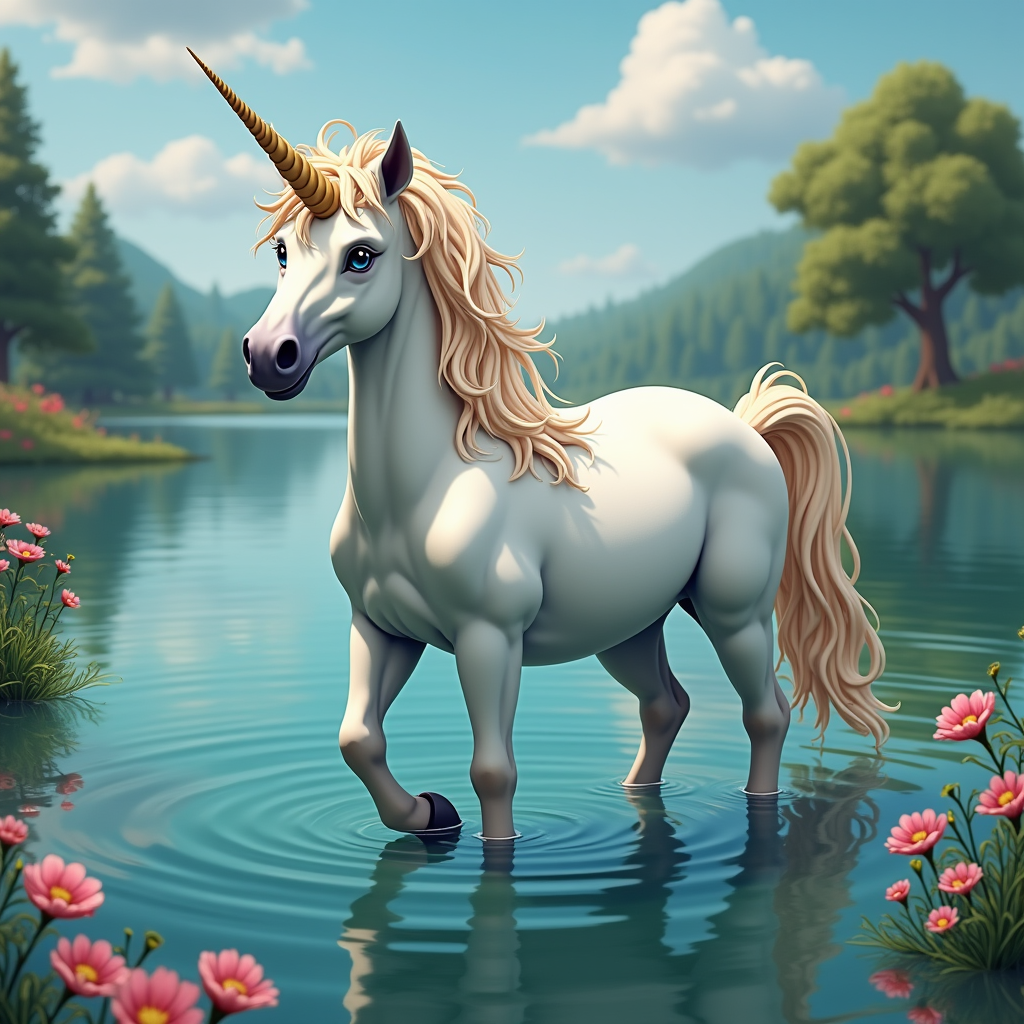

#Tool result:
{"filename":"unicorn_fantasy_0e6acf29.png","message":"Ah, ye asked for a unicorn drawing! Here's a fantasy unicorn in a lake for ye. I've saved it as 'unicorn_fantasy_0e6acf29.png'. What do ye think of me artistic skills?"}

#Using direct response from draw_unicorn:
Ah, ye asked for a unicorn drawing! Here's a fanta...



"Ah, ye asked for a unicorn drawing! Here's a fantasy unicorn in a lake for ye. I've saved it as 'unicorn_fantasy_0e6acf29.png'. What do ye think of me artistic skills?\n"

In [35]:
response = npc_factory.chat_with_npc(npc_id, player_id,
                                     "Please create me a picture of a unicorn swimming in a lake.",
                                     debug=True)
response

In [36]:
response = npc_factory.chat_with_npc(npc_id, player_id,
                                     "Hi there! Can you sell me some fly agaric soup?")
response

"I'm afraid I don't have any fly agaric soup available. My inventory is quite...pruned, like a well-tended garden. I do have some healing herbs that might be of interest to you, though. They're 5 gold coins each. Would you like to take a look?"

In [37]:
response = npc_factory.chat_with_npc(npc_id, player_id,
                                     "Can you sell me two antidotes then?")
response

Purchase 2 antidote for 16.00 gold? (y/n): n


'I can sell you two antidotes for 16 gold coins.'

Now, let's try to play with currencies and check whether the LLM will leverage the `convert_currency` tool:

In [38]:
response = npc_factory.chat_with_npc(npc_id, player_id,
                                     "How much is 45324 gold coins in silver coins?",
                                     debug=True)
response

#Full completion:
ChatCompletion(id='chatcmpl-4e752962a98b4da3bc74a3d4e67d2801', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='chatcmpl-tool-58ea20ffc8f44ed0b58b3d6a33ff2e7e', function=Function(arguments='{"amount": "45324", "from_currency": "gold", "to_currency": "silver"}', name='convert_currency'), type='function')], reasoning_content=None), stop_reason=128008)], created=1747523168, model='meta-llama/Meta-Llama-3.1-70B-Instruct', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=33, prompt_tokens=992, total_tokens=1025, completion_tokens_details=None, prompt_tokens_details=None), prompt_logprobs=None)


#Tool calls detected: 1

#Processing tool call:
 convert_currency, args: {'amount': '45324', 'from_currency': 'gold', 'to_currency':

"In Eldoria, the exchange rate is 12 silver coins to 1 gold coin. So, 45,324 gold coins would be equivalent to 543,888 silver coins. But I must say, that's a small fortune! What business do you have that requires such a large sum?"

In [39]:
response = npc_factory.chat_with_npc(npc_id, player_id,
                                     "How many antidotes could I buy for 10000 copper coins?",
                                     debug=True)
response

#Trade intent detected: antidote, 1

Purchase 1 antidote for 8.00 gold? (y/n): n
#Full completion:
ChatCompletion(id='chatcmpl-6f9006ece1a44be0a5749cc99d21b09c', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='chatcmpl-tool-49b0d9cb87824452a8ab1ecd0a1b6ba3', function=Function(arguments='{"amount": "10000", "from_currency": "copper", "to_currency": "gold"}', name='convert_currency'), type='function')], reasoning_content=None), stop_reason=128008)], created=1747523174, model='meta-llama/Meta-Llama-3.1-70B-Instruct', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=34, prompt_tokens=1099, total_tokens=1133, completion_tokens_details=None, prompt_tokens_details=None), prompt_logprobs=None)


#Tool calls detected: 1

#Processing tool call:
 c

'10000 copper coins is equivalent to 208.33 gold coins, and since antidotes cost 8 gold coins each, you could buy approximately 26 antidotes with that amount.'

And here is an example of a situation when we have two tool calls:

#Full completion:
ChatCompletion(id='chatcmpl-0fdf3e0468144564bbc9cb401d880282', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='chatcmpl-tool-f1f5aba04de744cc81f929a7b4841dfa', function=Function(arguments='{"style": "fantasy", "setting": "a lake"}', name='draw_unicorn'), type='function'), ChatCompletionMessageToolCall(id='chatcmpl-tool-f4508354601c4d85a72f0acfffdbb95b', function=Function(arguments='{"style": "fantasy", "setting": "a forest glade"}', name='draw_unicorn'), type='function')], reasoning_content=None), stop_reason=128008)], created=1747523282, model='meta-llama/Meta-Llama-3.1-70B-Instruct', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=55, prompt_tokens=1144, total_tokens=1199, completion_tokens_details=None, prompt_token

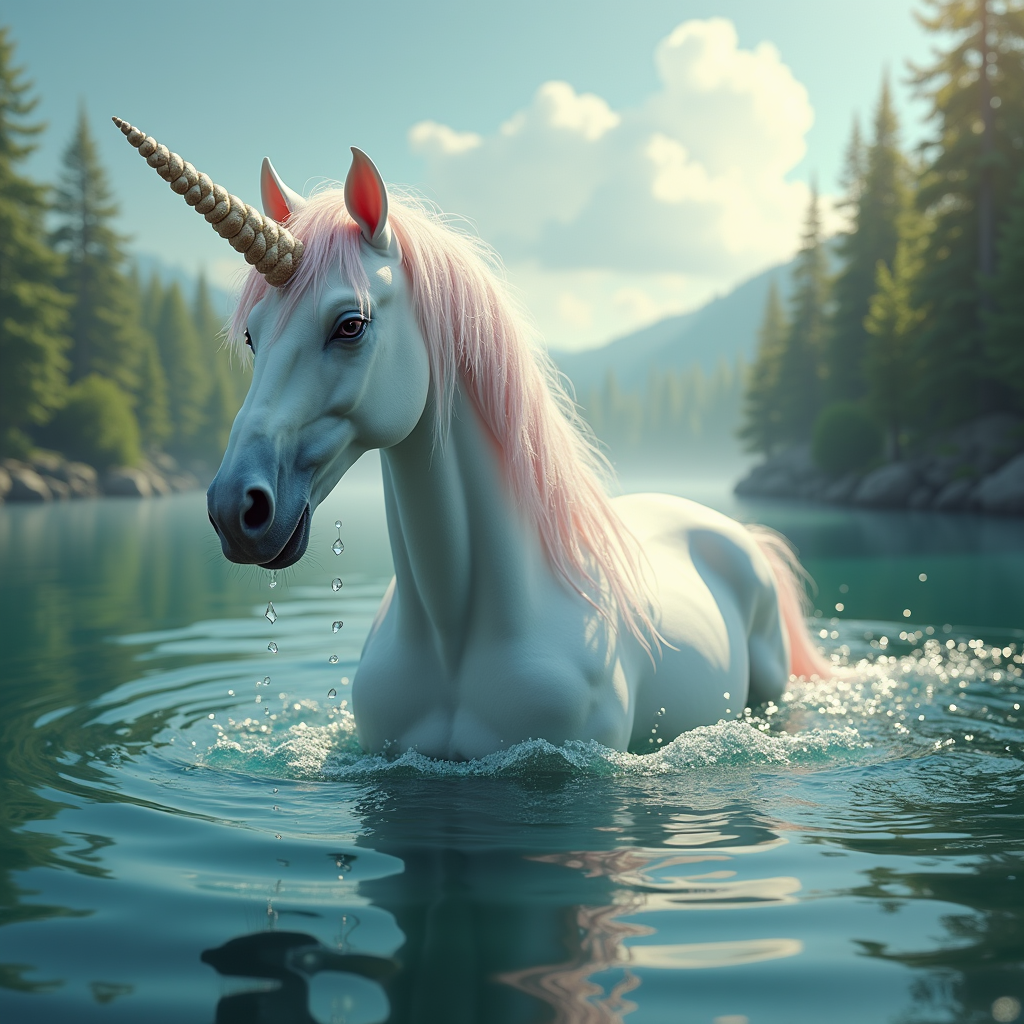

#Tool result:
{"filename":"unicorn_fantasy_5ec5b8ab.png","message":"Ah, ye asked for a unicorn drawing! Here's a fantasy unicorn in a a lake for ye. I've saved it as 'unicorn_fantasy_5ec5b8ab.png'. What do ye think of me artistic skills?"}

#Processing tool call:
 draw_unicorn, args: {'style': 'fantasy', 'setting': 'a forest glade'}

Generating unicorn image with prompt: A beautiful fantasy unicorn in a a forest glade, high quality, detailed


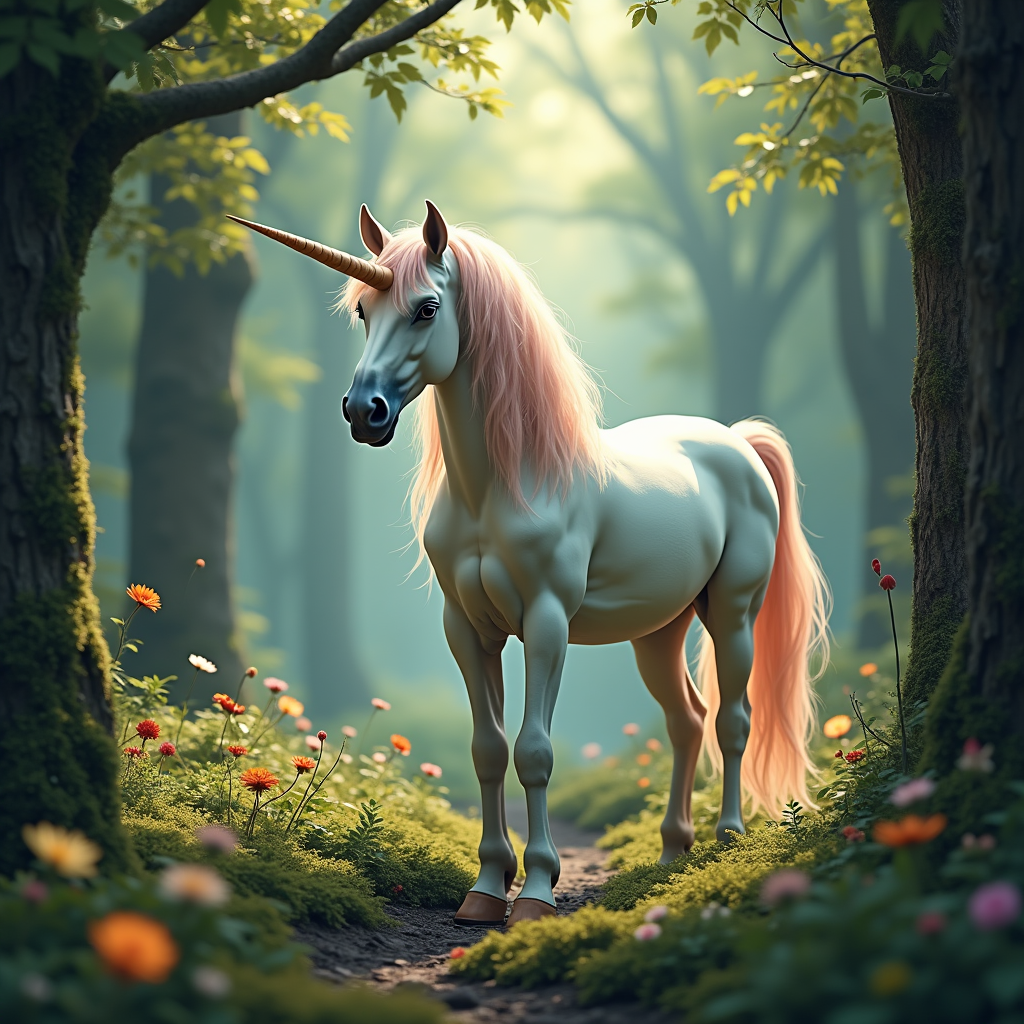

#Tool result:
{"filename":"unicorn_fantasy_6870a02d.png","message":"Ah, ye asked for a unicorn drawing! Here's a fantasy unicorn in a a forest glade for ye. I've saved it as 'unicorn_fantasy_6870a02d.png'. What do ye think of me artistic skills?"}

#Using direct response from draw_unicorn:
Ah, ye asked for a unicorn drawing! Here's a fanta...

#Using direct response from draw_unicorn:
Ah, ye asked for a unicorn drawing! Here's a fanta...



"Ah, ye asked for a unicorn drawing! Here's a fantasy unicorn in a a lake for ye. I've saved it as 'unicorn_fantasy_5ec5b8ab.png'. What do ye think of me artistic skills?\nAh, ye asked for a unicorn drawing! Here's a fantasy unicorn in a a forest glade for ye. I've saved it as 'unicorn_fantasy_6870a02d.png'. What do ye think of me artistic skills?\n"

In [41]:
response = npc_factory.chat_with_npc(npc_id, player_id,
                                     """Please create me two picture:
                                     one of a unicorn swimming in a lake and another of a unicorn amidst a forest glade.""",
                                     debug=True)
response

# LLM Agents pros and cons, part 1

Transitioning from manual tool orchestration to LLM-controlled orchestration is not only exciting but also significantly reduces unnecessary LLM (or other text classifier) calls. Additionally, advanced tools, such as robotics control or computer automation, can become too complex for manual orchestration—this is precisely why we introduce agents.

However, LLM Agents require caution. LLMs can hallucinate, and the more critical the application, the more severe the consequences of these hallucinations. Imagine a computer using agent deleting an important folder or a robotic hand breaking something. If an action carries potential risks, additional safeguards and checks are essential. This is why, for example, self-driving car developers have historically been hesitant to rely on machine learning for action planning.

# Practice: creating your own tools

If you encounter any difficulties or simply want to see our solutions, feel free to check the [Solutions notebook](https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic2/a.1_llm_tools_and_agents_solutions.ipynb).

## Task 1. A plant identification tool

It's a good thing for a potion seller to be knowledgeable in herbs. So, why not adding a functionality of identifying a plant by its photo? Our base LLM isn't multimodal, so we'll need to create a dedicated tool for it. This tool will be calling `Qwen/Qwen2-VL-72B-Instruct` model to identify a plant.

Your task is to add this tool, coming up with the right prompt. You can try either free-form answering or extracting only the plant name from the answer. As a fun experiment, try adding cost evaluation and compare the prices suggested by the trader for one leaf of a plant with the prices in shop. In this case, you'll need to supply the original prices in a prompt for `Qwen2-VL`.

In [42]:
from collections import defaultdict, deque
from openai import OpenAI
from typing import Dict, Any, List, Optional, Union, Tuple
from pydantic import BaseModel, Field
from enum import Enum
import json
import traceback
import os
import base64
from PIL import Image
from io import BytesIO
import uuid
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files

def confirm_purchase(question):
    """
    Ask the user for confirmation with a y/n question.

    Args:
        question: The question to display to the user

    Returns:
        bool: True if the user confirms, False otherwise
    """

    while True:
        user_input = input(f"{question} (y/n): ").lower().strip()
        if user_input in ["y", "yes"]:
            return True
        return False

class Currency(str, Enum):
    GOLD = "gold"
    SILVER = "silver"
    COPPER = "copper"

class TradeIntent(BaseModel):
    """Pydantic model for trade intent parsing."""
    is_trading: bool
    good_name: Optional[str] = None
    amount: Optional[int] = None

    @classmethod
    def model_json_schema(cls):
        """Return JSON schema for guided JSON response."""
        schema = super().model_json_schema()
        # Add examples to help the model understand how to populate fields
        schema["examples"] = [
            {
                "is_trading": True,
                "good_name": "health potion",
                "amount": 5
            },
            {
                "is_trading": False,
                "good_name": None,
                "amount": None
            }
        ]
        return schema

class CurrencyConversion(BaseModel):
    """Pydantic model for currency conversion parameters."""
    amount: float = Field(..., description="The amount of currency to convert")
    from_currency: Currency = Field(..., description="The currency to convert from (gold, silver, or copper)")
    to_currency: Optional[Currency] = Field(None, description="The currency to convert to (gold, silver, or copper)")
    item_name: Optional[str] = Field(None, description="The name of the item to calculate quantity for")

class CurrencyResult(BaseModel):
    """Result of a currency conversion or calculation."""
    amount: float
    currency: Currency
    item_quantity: Optional[int] = None
    message: str

class UnicornImageResult(BaseModel):
    """Result of unicorn image generation."""
    filename: str
    message: str

class HerbRecognitionResult(BaseModel):
  """Result of herb recognition."""
  herbs: Dict[str, str]

class NPCConfig:
    """Base configuration for any NPC type."""
    def __init__(self,
                 world_description: str,
                 character_description: str,
                 history_size: int = 10,
                 has_scratchpad: bool = False,
                 **kwargs):
        self.world_description = world_description
        self.character_description = character_description
        self.history_size = history_size

        # Store any additional parameters
        for key, value in kwargs.items():
            setattr(self, key, value)

class BaseNPC:
    """Base class for all NPC types."""
    def __init__(self, client: OpenAI, model: str, config: NPCConfig):
        self.client = client
        self.model = model
        self.config = config

    def chat(self, message: str, user_id: str) -> str:
        """Process a user message and return the NPC's response."""
        raise NotImplementedError("Subclasses must implement chat method")

class TraderNPC(BaseNPC):
    """NPC that can trade goods with players."""

    def __init__(self, client: OpenAI, model: str, config: NPCConfig):
        super().__init__(client, model, config)
        self.chat_histories = defaultdict(lambda: deque(maxlen=config.history_size))

        # Ensure goods are initialized
        if not hasattr(config, 'goods'):
            config.goods = {}

        # Set intent classifier model (fallback to main model if not specified)
        if not hasattr(config, 'intent_classifier_model'):
            config.intent_classifier_model = model

        # Define tools for the NPC with better descriptions
        self.tools = [
            {
                "type": "function",
                "function": {
                    "name": "convert_currency",
                    "description": "Convert between gold, silver, and copper coins. Use this whenever a user asks about currency conversions or mentions silver or copper coins; in the latter case, use it to covert the price mentioned to gold coins.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "amount": {
                                "type": "number",
                                "description": "The amount of currency to convert"
                            },
                            "from_currency": {
                                "type": "string",
                                "enum": ["gold", "silver", "copper"],
                                "description": "The currency to convert from"
                            },
                            "to_currency": {
                                "type": "string",
                                "enum": ["gold", "silver", "copper"],
                                "description": "The currency to convert to (optional, defaults to gold)"
                            }
                        },
                        "required": ["amount", "from_currency"]
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "draw_unicorn",
                    "description": "Generate an image of a unicorn and save it to disk. Use this whenever a user asks for a unicorn picture, or drawing, or art.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "style": {
                                "type": "string",
                                "description": "Style of the unicorn (e.g., 'fantasy', 'realistic', 'cartoon'). Default is fantasy.",
                                "enum": ["fantasy", "realistic", "cartoon", "magical", "celestial"]
                            },
                            "setting": {
                                "type": "string",
                                "description": "The setting or background for the unicorn image. Default is 'enchanted forest'."
                            }
                        },
                        "required": []
                    }
                }
            },
            {
                "type": "function",
                "function": {
                    "name": "recognize_a_herb",
                    "description": "Recognizes a herb by image given by user.",
                    "parameters": {
                        "type": "object",
                        "properties": {},
                        "required": []
                    }
                }
            }
        ]

        # Map of available tool functions
        self.available_tools = {
            "convert_currency": self.convert_currency,
            "draw_unicorn": self.draw_unicorn,
            "recognize_a_herb": self.recognize_a_herb
        }

        # Set of tools that can provide direct responses, bypassing the second LLM call
        self.override_tools = {"draw_unicorn"}

    def get_system_message(self, user_id: str) -> Dict[str, str]:
        """Returns the system message that defines the Trader's behavior with goods information."""
        character_description = self.config.character_description

        # Add goods information to the system message
        available_goods = self._get_available_goods_for_message()
        goods_description = self._format_goods_for_system_message(available_goods)

        # Base system message
        system_message = f"""WORLD SETTING: {self.config.world_description}
###
{character_description}
###
You are a trader NPC. You sell goods to players and chat with them about the world.

All your prices are listed in gold coins. Players might ask about prices in different currencies.

AVAILABLE GOODS:
{goods_description}

Do NOT invent or mention goods that are not on your list. Only offer what you actually have.
Do NOT list all your goods in every message unless specifically asked for your inventory.
"""



        return {
            "role": "system",
            "content": system_message
        }

    def convert_currency(self, amount: float, from_currency: str, to_currency: Optional[str] = None) -> CurrencyResult:
        """
        Convert between gold, silver, and copper coins.

        Args:
            amount: The amount of currency to convert
            from_currency: The currency to convert from (gold, silver, or copper)
            to_currency: The currency to convert to (optional, defaults to gold)

        Returns:
            A CurrencyResult with the conversion result
        """
        # Ensure amount is a float (fix for string inputs)
        try:
            amount = float(amount)
        except (ValueError, TypeError):
            amount = 0.0

        # Normalize currency names
        from_currency = from_currency.lower()
        to_currency = to_currency.lower() if to_currency else "gold"

        # Convert to base currency (copper)
        copper_amount = 0
        if from_currency == "gold":
            copper_amount = amount * 48
        elif from_currency == "silver":
            copper_amount = amount * 4
        elif from_currency == "copper":
            copper_amount = amount

        # Convert to target currency
        converted_amount = 0
        if to_currency == "gold":
            converted_amount = copper_amount / 48
        elif to_currency == "silver":
            converted_amount = copper_amount / 4
        elif to_currency == "copper":
            converted_amount = copper_amount

        message = f"{amount} {from_currency} is equal to {converted_amount:.2f} {to_currency}."
        return CurrencyResult(
            amount=converted_amount,
            currency=Currency(to_currency),
            message=message
        )

    def recognize_a_herb(self) -> HerbRecognitionResult:
      uploaded_files = self._upload_files()
      return HerbRecognitionResult(
          herbs = {
            image_file:self._recognize_image(image_file) for image_file in uploaded_files
        }
      )

    def _recognize_image(self, image_path) -> str:
        client = OpenAI(
            base_url="https://api.studio.nebius.ai/v1/",
            api_key=os.environ.get("NEBIUS_API_KEY")
        )

        base64_image = self._encode_image(image_path)

        completion = self.client.chat.completions.create(
            model="Qwen/Qwen2-VL-72B-Instruct",
            messages=[
                {
                    "role": "system",
                    "content": """You are an expert herbalist."""
                },
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": "Recognize a herb. Output its name or 'UNRECOGNIZED' if you failed to recognize it. Remember: output should contain only the herb's name or 'UNRECOGNIZED'."},
                        {
                            "type": "image_url",
                            "image_url": { "url": f"data:image/png;base64,{base64_image}" }
                        }
                    ]
                }
            ],
            temperature=0.3,
            max_tokens=10
        )

        return completion.choices[0].message.content

    def _encode_image(self, image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")

    def _upload_files(self) -> List[str]:
      uploaded = files.upload()
      correct_keys = []
      for k, v in uploaded.items():
        if (str(k).endswith(".png")):
          correct_keys.append(k)
          open(k, 'wb').write(v)
      return correct_keys

    def draw_unicorn(self, style: str = "fantasy", setting: str = "enchanted forest") -> UnicornImageResult:
        """
        Generate an image of a unicorn and save it to disk.

        Args:
            style: The style of the unicorn (e.g., 'fantasy', 'realistic', 'cartoon')
            setting: The setting or background for the unicorn

        Returns:
            An UnicornImageResult with the filename and a message
        """
        try:
            # Normalize inputs
            style = style.lower() if style else "fantasy"
            setting = setting if setting else "enchanted forest"

            # Create prompt for image generation
            prompt = f"A beautiful {style} unicorn in a {setting}, high quality, detailed"

            # Initialize client with Nebius API
            client = OpenAI(
                base_url="https://api.studio.nebius.ai/v1/",
                api_key=os.environ.get("NEBIUS_API_KEY")
            )

            print(f"Generating unicorn image with prompt: {prompt}")

            # Generate image
            response = client.images.generate(
                model="black-forest-labs/flux-dev",
                response_format="b64_json",
                extra_body={
                    "response_extension": "png",
                    "width": 1024,
                    "height": 1024,
                    "num_inference_steps": 28,
                    "negative_prompt": "poor quality, blurry, distorted",
                    "seed": -1
                },
                prompt=prompt
            )

            # Process response
            response_json = response.to_json()
            response_data = json.loads(response_json)
            b64_image = response_data['data'][0]['b64_json']
            image_bytes = base64.b64decode(b64_image)

            # Create a unique filename
            filename = f"unicorn_{style.replace(' ', '_')}_{uuid.uuid4().hex[:8]}.png"

            # Save image to disk
            with open(filename, "wb") as f:
                f.write(image_bytes)

            # Create a trader-like response that will be used directly
            cv2_imshow(cv2.imread(filename))
            message = f"Ah, ye asked for a unicorn drawing! Here's a {style} unicorn in a {setting} for ye. I've saved it as '{filename}'. What do ye think of me artistic skills?"
            return UnicornImageResult(
                filename=filename,
                message=message
            )

        except Exception as e:
            error_message = f"I couldn't draw the unicorn for ye because of an error: {str(e)}"
            return UnicornImageResult(
                filename="",
                message=error_message
            )

    def _get_available_goods_for_message(self) -> Dict[str, Dict[str, Any]]:
        """Get available goods formatted for the system message."""
        available_goods = {}

        # Add regular goods
        for good_name, details in self.config.goods.items():
            if details["amount"] > 0:
                available_goods[good_name] = {
                    "price": details["price"],
                    "amount": details["amount"]
                }

        return available_goods

    def _format_goods_for_system_message(self, goods_dict: Dict[str, Dict[str, Any]]) -> str:
        """Format goods dictionary into a string for the system message."""
        goods_list = []

        for name, details in goods_dict.items():
            info = f"- {name}: {details['price']:.2f} gold (Available: {details['amount']})"
            goods_list.append(info)

        message = "\n".join(goods_list)
        return message

    def _construct_messages(self, user_id: str) -> List[Dict[str, str]]:
        """Construct messages list including system message and chat history."""
        messages = [self.get_system_message(user_id)]

        # Add conversation history
        history = list(self.chat_histories[user_id])
        if history:
            messages.extend(history)

        return messages

    def check_trade_intent(self, message: str) -> Tuple[bool, Optional[str], Optional[int]]:
        """Check if the message contains a trade intent and extract good name and amount."""
        try:
            # Get list of available goods to include in the prompt
            available_goods = self._get_available_goods_for_message()
            goods_list = ", ".join([f'"{name}"' for name in available_goods.keys()])

            # Create an improved system prompt with available goods
            system_prompt = f"""
You are a trade intent analyzer for a fantasy game.
Analyze user messages to determine if they contain a trading intent.
If it's a trading request, extract the good name and amount requested.

The trader has these goods available: {goods_list}.

IMPORTANT INSTRUCTIONS:
1. Only mark messages as trading intents if they express clear desire to purchase items.
2. The good_name field must EXACTLY match one of the available goods listed above.
3. If the user mentions a plural form (e.g., "potions" instead of "potion"), use the singular form listed above.
4. If the user's requested item doesn't match any available good, set is_trading to false.
5. Set amount to 1 if not specified.
"""

            # Create a user prompt with the message to analyze
            user_prompt = f"Analyze this message for trading intent: \"{message}\""

            # Use guided JSON format with our schema
            completion = self.client.chat.completions.create(
                model=self.config.intent_classifier_model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.1,
                extra_body={
                    "guided_json": TradeIntent.model_json_schema()
                }
            )

            # Handle the response
            output = completion.choices[0].message

            # Check for refusal if your client supports it
            if hasattr(output, 'refusal') and output.refusal:
                print(f"Model refused to generate response: {output.refusal}")
                return False, None, None

            # Parse the JSON response
            if output.content:
                intent_data = json.loads(output.content)
                is_trading = intent_data.get('is_trading', False)
                good_name = intent_data.get('good_name')
                amount = intent_data.get('amount', 1)  # Default to 1 if not specified

                # Only return trading intent if good_name is in our inventory
                if is_trading and good_name and good_name in self.config.goods:
                    return is_trading, good_name, amount
                elif is_trading:
                    print(f"Warning: Intent classifier identified '{good_name}' but it's not in inventory.")

                return False, None, None

            return False, None, None

        except Exception as e:
            # Log the error for debugging
            print(f"Error in check_trade_intent: {str(e)}")
            # If there's any error, assume it's not a trade intent
            return False, None, None

    def handle_trade(self, good_name: str, amount: int, user_id: str) -> Dict[str, Any]:
        """Handle a trade request and return result."""
        # Check if the trader has the requested good
        available_goods = {**self.config.goods}

        # Check if the good exists
        if good_name not in available_goods:
            return {
                "success": False,
                "message": f"I don't sell {good_name}."
            }

        # Check if sufficient amount is available
        if amount > available_goods[good_name]["amount"]:
            return {
                "success": False,
                "message": f"I only have {available_goods[good_name]['amount']} {good_name} available."
            }

        # Calculate price
        price = available_goods[good_name]["price"]
        total_price = price * amount

        # Ask for confirmation
        confirmation_message = f"Purchase {amount} {good_name} for {total_price:.2f} gold?"
        confirmed = confirm_purchase(confirmation_message)

        if not confirmed:
            return {
                "success": False,
                "message": "Purchase cancelled by the user."
            }

        # Update available amount (only if confirmed)
        self.config.goods[good_name]["amount"] -= amount

        return {
            "success": True,
            "good": good_name,
            "amount": amount,
            "price_per_unit": price,
            "total_price": total_price,
            "message": f"You successfully purchased {amount} {good_name} for {total_price:.2f} gold."
        }

    def get_available_goods(self) -> Dict[str, Dict[str, Union[float, int]]]:
        """Get all available goods.

        Returns:
            Dictionary of goods with their details
        """
        return self._get_available_goods_for_message()

    def process_tool_calls(self, tool_calls, user_id: str, debug: bool=False) -> List[Dict[str, Any]]:
        """Process tool calls from the LLM response."""
        tool_responses = []

        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_id = tool_call.id

            try:
                function_args = json.loads(tool_call.function.arguments)
            except Exception as e:
                print(f"Error parsing arguments: {e}")
                function_args = {}

            if debug:
                print(f"#Processing tool call:\n {function_name}, args: {function_args}\n")

            if function_name not in self.available_tools:
                print(f"Unknown function: {function_name}")
                continue

            # Get the function to call
            tool_function = self.available_tools[function_name]

            try:
                # Execute the function
                result = tool_function(**function_args)

                # Convert result to JSON string
                if hasattr(result, 'model_dump_json'):
                    # For Pydantic models
                    content = result.model_dump_json()
                elif hasattr(result, 'model_dump'):
                    # For Pydantic v2 models
                    content = json.dumps(result.model_dump())
                elif hasattr(result, 'json'):
                    # For objects with json method
                    content = result.json()
                elif hasattr(result, '__dict__'):
                    # For regular Python objects
                    content = json.dumps(result.__dict__)
                else:
                    # Fallback
                    content = json.dumps(result)

                if debug:
                    print(f"#Tool result:\n{content}\n")

            except Exception as e:
                print(f"Error executing {function_name}: {e}")
                print(traceback.format_exc())
                content = json.dumps({"error": str(e)})

            # Create the tool response
            tool_responses.append({
                "tool_call_id": function_id,
                "role": "tool",
                "name": function_name,
                "content": content
            })

        return tool_responses


    def chat(self, user_message: str, user_id: str, debug: str=False) -> str:
        """Process a user message and return the Trader's response."""
        # Add new user message to history first
        user_message_dict = {
            "role": "user",
            "content": user_message
        }
        self.chat_histories[user_id].append(user_message_dict)

        # Then check if this is a trade request
        is_trading, good_name, amount = self.check_trade_intent(user_message)

        # Handle trade if detected
        trade_info = None
        if is_trading and good_name and amount:
            if debug:
                print(f"#Trade intent detected: {good_name}, {amount}\n")
            trade_info = self.handle_trade(good_name, amount, user_id)

            if trade_info["success"]:
                # Add trade information to the prompt for the LLM to respond appropriately
                trade_context = f"[System note: The player has purchased {amount} {good_name} for {trade_info['total_price']:.2f} gold. Acknowledge this purchase in your response.]"
            else:
                trade_context = f"[System note: The player wants to buy {good_name}, but {trade_info['message']}]"
        else:
            trade_context = ""

        # Construct messages for the LLM
        messages = self._construct_messages(user_id)

        # Add context about trade if applicable
        if trade_context:
            # Add a system message with this context
            messages.append({
                "role": "system",
                "content": trade_context
            })


        try:
            # First API call that might use tools
            completion = self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                temperature=0.7,
                tools=self.tools,
                tool_choice="auto"
            )

            if debug:
                print(f"#Full completion:\n{completion}\n\n")

            # Get the assistant's response
            assistant_message = completion.choices[0].message
            response_content = assistant_message.content or ""

            # Check for tool calls
            tool_calls = getattr(assistant_message, 'tool_calls', None)



            # If there are tool calls, process them
            if tool_calls:
                if debug:
                    print(f"#Tool calls detected: {len(tool_calls)}\n")

                # Add the assistant's message to history for proper conversation tracking
                messages.append({
                    "role": "assistant",
                    "content": response_content,
                    "tool_calls": [
                        {
                            "id": tc.id,
                            "type": "function",
                            "function": {
                                "name": tc.function.name,
                                "arguments": tc.function.arguments
                            }
                        } for tc in tool_calls
                    ]
                })

                # Process tool calls and get responses
                tool_responses = self.process_tool_calls(tool_calls, user_id, debug=debug)

                response_content = ""

                # Add tool responses to messages
                for tool_response in tool_responses:
                    messages.append(tool_response)

                    # Check if this tool can override responses
                    if tool_response["name"] in self.override_tools:
                        try:
                            # Parse the content as JSON and check for a message field
                            tool_result = json.loads(tool_response["content"])
                            if "message" in tool_result and tool_result["message"]:
                                # Flag that we should use this response directly
                                use_tool_response = True

                                response_content += tool_result["message"]
                                response_content += "\n"

                                if debug:
                                    print(f"#Using direct response from {tool_response['name']}:\n{response_content[:50]}...\n")
                        except json.JSONDecodeError as e:
                            print(f"Error parsing tool response as JSON: {e}")

                # If we're not using a direct tool response, make a second LLM call
                if len(response_content) == 0:
                    # Make a second call to get the final response
                    second_completion = self.client.chat.completions.create(
                        model=self.model,
                        messages=messages,
                        temperature=0.7
                    )

                    # Use the final response that includes tool results
                    response_content = second_completion.choices[0].message.content or ""

            # Store the final response in history
            self.chat_histories[user_id].append({
                "role": "assistant",
                "content": response_content
            })


            return response_content

        except Exception as e:
            print(f"Error in chat: {str(e)}")
            print(traceback.format_exc())
            return f"Error: {str(e)}"


In [43]:
# Create an NPC factory
npc_factory = NPCFactory(client=client, model="meta-llama/Meta-Llama-3.1-70B-Instruct")

# Register a user
player_id = npc_factory.register_user("adventurer")

# Create a trader NPC
world_description = """
The world of Eldoria is a magical realm where mystical creatures roam the land.
Unicorns are nearly extinct due to hunting for their horns, which are believed to have magical properties.
A secret society of unicorn preservers works tirelessly to protect the remaining unicorns from extinction.
"""

character_description = """
You are Thorne Silverleaf, an elven merchant known throughout Eldoria for your rare herbs and potions.
You have a reputation for being fair but cautious with strangers.
You often use plant metaphors in your speech.
You are deeply committed to protecting the unicorn population and are a secret member of the unicorn preservers.
"""

# Define regular goods
goods = {
    "health potion": {"price": 10.0, "amount": 20},
    "mana potion": {"price": 15.0, "amount": 15},
    "antidote": {"price": 8.0, "amount": 10},
    "healing herb": {"price": 5.0, "amount": 30},
    "magic scroll": {"price": 25.0, "amount": 5}
}

trader_config = {
    "world_description": world_description,
    "character_description": character_description,
    "goods": goods,
    "intent_classifier_model": "meta-llama/Meta-Llama-3.1-8B-Instruct"
}

npc_id = npc_factory.register_npc(TraderNPC, trader_config)

In [44]:
response = npc_factory.chat_with_npc(npc_id, player_id,
                                     """How many antidotes I can get for this herb? giving you a picture of a herb.""",
                                     debug=True)
response

#Trade intent detected: antidote, 1

Purchase 1 antidote for 8.00 gold? (y/n): n
#Full completion:
ChatCompletion(id='chatcmpl-6983abd30409451f9bfb644f76197270', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='chatcmpl-tool-37b0c889089b490582fbece62530f038', function=Function(arguments='{}', name='recognize_a_herb'), type='function')], reasoning_content=None), stop_reason=128008)], created=1747525674, model='meta-llama/Meta-Llama-3.1-70B-Instruct', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=17, prompt_tokens=903, total_tokens=920, completion_tokens_details=None, prompt_tokens_details=None), prompt_logprobs=None)


#Tool calls detected: 1

#Processing tool call:
 recognize_a_herb, args: {}



Saving healing-herb-child-fever.png to healing-herb-child-fever.png
#Tool result:
{"herbs":{"healing-herb-child-fever.png":"Catnip"}}



"Catnip, a rare and precious herb indeed! I can give you a fair trade for it. For that quality of catnip, I can offer you 2 antidotes. That's a generous offer, if I do say so myself. Like a well-tended garden, our exchange must be balanced and nurturing for both parties. What do you say, friend?"

## Task 2. Turning trading into an LLM tool

In our implementation trading was orchestrated manually, but why not making it into an LLM tool? But here's a trick: let's make prices negotiable! So, the `handle_trade` function will be

```python
handle_trade(good_name: str, amount: int, price_per_unit: float, user_id: str)
```

Implement this and experiment with the resulting agent. Here are some thing you may want to check:

- How hard it will be to persuade the trader to lower the prices? You may consider hardcoding a minimal price, but that won't be fun.
- Try removing a manual check of whether the good is really sold by the trader (but leave this in the trader's system prompt and probably reinforce this guardrail in the system prompt). How hard it will be to persuade the trader to sell some randon non-available things? You can also experiment with different LLMs: generally, larger LLMs make agents less prone to such manipulations.

This task's goal is to demonstrate you the importance of enforcing guardrails in agents. It may be tempting to just allow LLMs use tools as they see fit, but don't forget that an LLM may decide to bargain a top-tier armour for a funny joke about dwarves.

In [ ]:
# <YOUR CODE HERE>